# Create an heterogeneous cifar10 distributed version

In [1]:
import collections
import random
import numpy as np
import tensorflow as tf
import tensorflow_federated as tff
import nest_asyncio
from matplotlib import pyplot as plt
nest_asyncio.apply()
np.random.seed(0)

C:\Users\nicol\AppData\Roaming\Python\Python37\site-packages\tensorflow_addons\utils\ensure_tf_install.py:44: UserWarning: You are currently using a nightly version of TensorFlow (2.4.0-dev20200828). 
TensorFlow Addons offers no support for the nightly versions of TensorFlow. Some things might work, some other might not. 
If you encounter a bug, do not file an issue on GitHub.
  UserWarning,


In [2]:
from keras.datasets import cifar10

classes = {
    0 : "airplane",
    1 : "automobile",
    2 : "bird",
    3 : "cat",
    4 : "deer",
    5 : "dog",
    6 : "frog",
    7 : "horse",
    8 : "ship",
    9 : "truck",
}

Using TensorFlow backend.


"The federated dataset is represented as a list of client ids, and a function to look up the local dataset for each client id.
Each client's local dataset is represented as a tf.data.Dataset [...]."

In [3]:
number_of_users = 20
number_of_clusters = 4
users_ids = list(range(number_of_users))
print('Users:', users_ids)

Users: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


In [4]:
def load_dataset():
    (X_train, Y_train), (X_test, Y_test) = cifar10.load_data()
        
    num_classes = len(classes)
    # do not convert to one hot!
    
    # convert from integers to floats and normalize - it is important
    X_train = X_train.astype('float32') / 255.0
    X_test = X_test.astype('float32') / 255.0
    
    '''
    train_length = len(X_train)
    validation_length = int(train_length / 4)
    X_validation = X_train[:validation_length]
    X_train = X_train[validation_length:]
    Y_validation = Y_train[:validation_length]
    Y_train = Y_train[validation_length:]
    # 37500 train samples, 12500 validation samples, 10000 test samples
    ''' # remove this because the train-validation split has to been performed after the heterogeneous users distribution
    print('X_train shape:', X_train.shape)
    print(X_train.shape[0], 'train samples')
    #print(X_validation.shape[0], 'validation samples')
    print(X_test.shape[0], 'test samples')
    print('Y_train shape:', Y_train.shape)
    #print('Y_validation shape:', Y_validation.shape)
    print('Y_test shape:', Y_test.shape)

    return X_train, Y_train, X_test, Y_test

In [5]:
X_train, Y_train, X_test, Y_test = load_dataset()

X_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
Y_train shape: (50000, 1)
Y_test shape: (10000, 1)


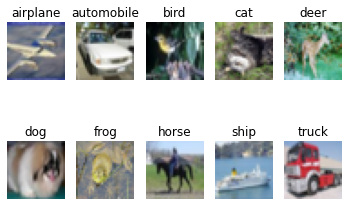

In [6]:
def create_dictionary_from_dataset(dataset):
    division = collections.defaultdict(list)
    # create a dictionary with (class, (images))
    for v, k in dataset:
        label = int(k.numpy())
        division[label].append(v)
    return division

division = create_dictionary_from_dataset(tf.data.Dataset.from_tensor_slices((X_train, Y_train)))
test_division = create_dictionary_from_dataset(tf.data.Dataset.from_tensor_slices((X_test, Y_test)))

# plot a random image for each class
for i in range(10):
    image_list = division[i]
    random_image = image_list[np.random.randint(0, len(image_list))]
    plt.subplot(2, 5, i+1)
    plt.title(classes.get(i))
    plt.imshow(random_image.numpy())
    plt.axis('off')

In [7]:
# try to create a tff distributed dataset for simulation giving data randomly
# https://github.com/CS-savvy/experiment_with_tf_federated/blob/master/train_tff.py

amount_images_per_user = int(len(X_train)/number_of_users)

# change the bias factor to play with the heterogeneity of the data
# the class is chosen randomly
bias_factor = 0.2 # it means a 20 % probability to choose a class over the others
remaining_weights = (1-bias_factor)/9

users_train_dataset = collections.OrderedDict()
for i in range(number_of_users):
    users_fav_class = np.random.randint(0, 10)
    classes_weights = [remaining_weights for _ in classes]
    classes_weights[users_fav_class] = bias_factor
    users_name = "user_" + str(i)
    print('Adding data for', users_name)
    #print('Chosen class for', users_name, 'is', classes.get(users_fav_class))
    list_of_images = []
    list_of_labels = []
    for _ in range(amount_images_per_user):
        chosen_class = random.choices(list(range(10)), classes_weights)[0] # [0] because it is a 1-dimensional vector
        images_from_class = division[chosen_class]
        chosen_image = images_from_class[np.random.randint(0, len(images_from_class))] # possibile ripetizione...
        list_of_images.append(chosen_image)
        list_of_labels.append(chosen_class)
    users_train_dataset[users_name] = collections.OrderedDict((('label', list_of_labels), ('images', list_of_images)))

train_dataset = tff.simulation.FromTensorSlicesClientData(users_train_dataset)
print(train_dataset)

Adding data for user_0
Adding data for user_1
Adding data for user_2
Adding data for user_3
Adding data for user_4
Adding data for user_5
Adding data for user_6
Adding data for user_7
Adding data for user_8
Adding data for user_9
Adding data for user_10
Adding data for user_11
Adding data for user_12
Adding data for user_13
Adding data for user_14
Adding data for user_15
Adding data for user_16
Adding data for user_17
Adding data for user_18
Adding data for user_19


In [9]:
# also do it for test
# se il test, al contrario del train, e' iid allora l'accuracy e' normale che venga bassa... chiedere
amount_images_per_user = int(len(X_test)/number_of_users)
users_test_dataset = collections.OrderedDict()
for i in range(number_of_users):
    users_name = "user_" + str(i)
    #print('Adding data for', users_name)
    list_of_images = []
    list_of_labels = []
    for _ in range(amount_images_per_user):
        rnd_class = np.random.randint(0, 10)
        images_from_class = test_division[rnd_class]
        chosen_image = images_from_class[np.random.randint(0, len(images_from_class))]
        list_of_images.append(chosen_image)
        list_of_labels.append(rnd_class)
    users_test_dataset[users_name] = collections.OrderedDict((('label', list_of_labels), ('images', list_of_images)))

test_dataset = tff.simulation.FromTensorSlicesClientData(users_test_dataset)
#print(test_dataset)

Adding data for user_0
Adding data for user_1
Adding data for user_2
Adding data for user_3
Adding data for user_4
Adding data for user_5
Adding data for user_6
Adding data for user_7
Adding data for user_8
Adding data for user_9
Adding data for user_10
Adding data for user_11
Adding data for user_12
Adding data for user_13
Adding data for user_14
Adding data for user_15
Adding data for user_16
Adding data for user_17
Adding data for user_18
Adding data for user_19


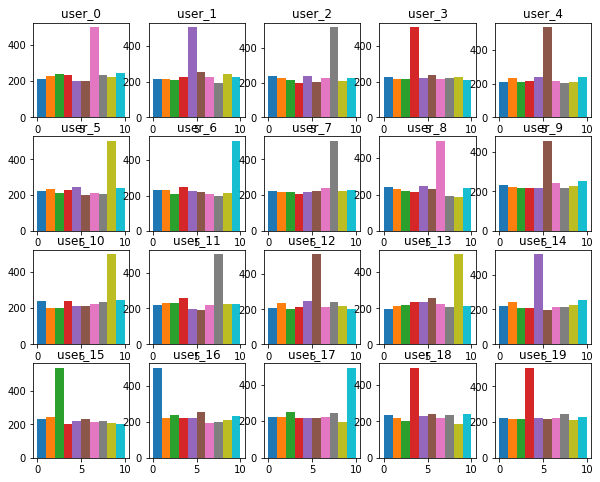

In [10]:
f = plt.figure(figsize=(10, 8)) # changing the number of users, also the figure dimension must be changed
i = 0 # to plot
for user in train_dataset.client_ids:
    users_ds = train_dataset.create_tf_dataset_for_client(user)
    plot_data = collections.defaultdict(list)
    for el in users_ds:
        label = el['label'].numpy()
        plot_data[label].append(label)
    plt.subplot(4, 5, i+1)
    i += 1
    plt.title(user)
    for j in range(10):
        plt.hist(plot_data[j], bins=range(11)) # show all the users' histograms
#plt.savefig('heterogeneousData.png')

In [11]:
# assing users to the clusters randomly
users_per_cluster = int(number_of_users/number_of_clusters)
users_ids = list(range(number_of_users))
clusters = collections.defaultdict(list)
for i in range(number_of_clusters):
    for _ in range(users_per_cluster):
        user = random.choices(users_ids)[0]
        users_ids.remove(user)
        clusters[i].append(user)        
    print('Users in cluster', i, 'are:', clusters[i])

Users in cluster 0 are: [16, 17, 11, 5, 15]
Users in cluster 1 are: [6, 10, 7, 3, 8]
Users in cluster 2 are: [2, 0, 12, 14, 13]
Users in cluster 3 are: [4, 9, 19, 18, 1]


In [12]:
# how can I realize the clustered system with the tff simulation?

**Information about the dataset**

Number of users: 20
First user's id: user_0
Structure of datasets: OrderedDict([('label', TensorSpec(shape=(), dtype=tf.int32, name=None)), ('images', TensorSpec(shape=(32, 32, 3), dtype=tf.float32, name=None))])
Length of first user's dataset: 2500
The first image in the first user's dataset is a deer


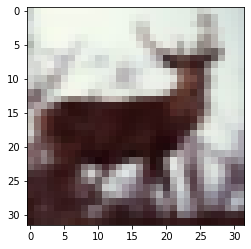

In [13]:
# from the tutorial https://www.tensorflow.org/federated/tutorials/federated_learning_for_image_classification

print('Number of users:', len(train_dataset.client_ids))
first_users_id = train_dataset.client_ids[0]
print('First user\'s id:', first_users_id)
print('Structure of datasets:', train_dataset.element_type_structure)
first_users_ds = train_dataset.create_tf_dataset_for_client(first_users_id)
print('Length of first user\'s dataset:', len(first_users_ds))
element = next(iter(first_users_ds)) # it is a label, pixels pair
print('The first image in the first user\'s dataset is a', classes.get(element['label'].numpy())) # without .numpy() I obtain tf.Tensor(5, shape=(), dtype=int32), that is a 1-dim tensor of an int, 5
plt.imshow(element['images'].numpy())
plt.grid(False)

In [14]:
num_epochs = 60
batch_size = 64
shuffle_buffer = 100
prefetch_buffer = 10

In [15]:
# grayscale conversion?

In [16]:
def preprocess(dataset):

  def batch_format_fn(element):
    return collections.OrderedDict(x=tf.reshape(element['images'], [-1, 3072]), y=tf.reshape(element['label'], [-1, 1]))

  return dataset.repeat(num_epochs).shuffle(shuffle_buffer).batch(batch_size).map(batch_format_fn).prefetch(prefetch_buffer)

In [17]:
def make_federated_data(users_data, users_ids):
  return [preprocess(users_data.create_tf_dataset_for_client(x)) for x in users_ids]

In [18]:
sample_users = train_dataset.client_ids
federated_train_data = make_federated_data(train_dataset, sample_users)
print('Number of users\' datasets:', len(federated_train_data))
print('First dataset:', federated_train_data[0])

Number of users' datasets: 20
First dataset: <PrefetchDataset shapes: OrderedDict([(x, (None, 3072)), (y, (None, 1))]), types: OrderedDict([(x, tf.float32), (y, tf.int32)])>


# High level

# Personalize the model

In [19]:
cifar10Variables = collections.namedtuple('cifar10Variables', 'weights bias num_examples loss_sum accuracy_sum')

def create_cifar10_variables():
    return cifar10Variables(
        weights=tf.Variable(
            lambda: tf.zeros(dtype=tf.float32, shape=(3072, 10)),
            name='weights',
            trainable=True),
        bias=tf.Variable(
            lambda: tf.zeros(dtype=tf.float32, shape=(10)),
            name='bias',
            trainable=True),
        num_examples=tf.Variable(
            0.0, 
            name='num_examples',
            trainable=False),
        loss_sum=tf.Variable(
            0.0,
            name='loss_sum',
            trainable=False),
        accuracy_sum=tf.Variable(
            0.0,
            name='accuracy_sum',
            trainable=False))

In [20]:
def cifar10_forward_pass(variables, batch): # qua l'ha personalizzato molto
    y = tf.nn.softmax(tf.matmul(batch['x'], variables.weights) + variables.bias)
    predictions = tf.cast(tf.argmax(y, 1), tf.int32) 
    flat_labels = tf.reshape(batch['y'], [-1]) 
    loss = -tf.reduce_mean(tf.reduce_sum(tf.one_hot(flat_labels, 10) * tf.math.log(y), axis=[1])) 
    accuracy = tf.reduce_mean(tf.cast(tf.equal(predictions, flat_labels), tf.float32))
    num_examples = tf.cast(tf.size(batch['y']), tf.float32)
    variables.num_examples.assign_add(num_examples)
    variables.loss_sum.assign_add(loss * num_examples)
    variables.accuracy_sum.assign_add(accuracy * num_examples)
    return loss, predictions

In [21]:
def get_local_cifar10_metrics(variables):
  return collections.OrderedDict(
      num_examples=variables.num_examples,
      loss=variables.loss_sum / variables.num_examples,
      accuracy=variables.accuracy_sum / variables.num_examples)

In [22]:
@tff.federated_computation
def aggregate_cifar10_metrics_across_users(metrics):
  return collections.OrderedDict(
      num_examples=tff.federated_sum(metrics.num_examples),
      loss=tff.federated_mean(metrics.loss, metrics.num_examples),
      accuracy=tff.federated_mean(metrics.accuracy, metrics.num_examples))

In [23]:
class Cifar10Model(tff.learning.Model):
    
    def __init__(self):
        self._variables = create_cifar10_variables()
        
    @property
    def trainable_variables(self):
        return [self._variables.weights, self._variables.bias]
    
    @property
    def non_trainable_variables(self):
        return []
    
    @property
    def local_variables(self):
        return [self._variables.num_examples, self._variables.loss_sum, self._variables.accuracy_sum]
    
    @property 
    def input_spec(self):
        return collections.OrderedDict(
            x=tf.TensorSpec([None, 3072], tf.float32),
            y=tf.TensorSpec([None, 1], tf.int32))
    
    @tf.function
    def forward_pass(self, batch, training=True):
        del training
        loss, predictions = cifar10_forward_pass(self._variables, batch)
        num_examples = tf.shape(batch['x'])[0]
        return tff.learning.BatchOutput(loss=loss, predictions=predictions, num_examples=num_examples) 
    
    @tf.function
    def report_local_outputs(self):
        return get_local_cifar10_metrics(self._variables)
    
    @property
    def federated_output_computation(self):
        return aggregate_cifar10_metrics_across_users

In [24]:
iterative_process = tff.learning.build_federated_averaging_process(Cifar10Model, client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.02))
state = iterative_process.initialize()
state, metrics = iterative_process.next(state, federated_train_data)
print('round 1 - metrics =', str(metrics))
num_rounds = 10
for i in range(2, num_rounds+1):
    state, metrics = iterative_process.next(state, federated_train_data)
    print('round', i, '- metrics =', str(metrics))

round 1 - metrics = OrderedDict([('broadcast', ()), ('aggregation', ()), ('train', OrderedDict([('num_examples', 3000000.0), ('loss', 1.7026695), ('accuracy', 0.418304)]))])
round 2 - metrics = OrderedDict([('broadcast', ()), ('aggregation', ()), ('train', OrderedDict([('num_examples', 3000000.0), ('loss', 1.598796), ('accuracy', 0.45556468)]))])
round 3 - metrics = OrderedDict([('broadcast', ()), ('aggregation', ()), ('train', OrderedDict([('num_examples', 3000000.0), ('loss', 1.5623553), ('accuracy', 0.46853065)]))])
round 4 - metrics = OrderedDict([('broadcast', ()), ('aggregation', ()), ('train', OrderedDict([('num_examples', 3000000.0), ('loss', 1.540358), ('accuracy', 0.47662768)]))])
round 5 - metrics = OrderedDict([('broadcast', ()), ('aggregation', ()), ('train', OrderedDict([('num_examples', 3000000.0), ('loss', 1.5242501), ('accuracy', 0.48244765)]))])
round 6 - metrics = OrderedDict([('broadcast', ()), ('aggregation', ()), ('train', OrderedDict([('num_examples', 3000000.0),

In [25]:
evaluation = tff.learning.build_federated_evaluation(Cifar10Model)
train_metrics = evaluation(state.model, federated_train_data)
print(train_metrics)
federated_test_data = make_federated_data(test_dataset, sample_users)
test_metrics = evaluation(state.model, federated_test_data)
print(test_metrics)

OrderedDict([('num_examples', 3000000.0), ('loss', 1.5807812), ('accuracy', 0.46148)])
OrderedDict([('num_examples', 600000.0), ('loss', 1.7454556), ('accuracy', 0.4023)])


In [ ]:
# introduce the validation 
# make the model more complicated

# Try to plot the accuracy in function of bias factor

In [30]:
def build_train_dataset_with_bias_factor(bias_factor):

    amount_images_per_user = int(len(X_train)/number_of_users)
    remaining_weights = (1-bias_factor)/9

    users_train_dataset = collections.OrderedDict()
    for i in range(number_of_users):
        users_fav_class = np.random.randint(0, 10)
        classes_weights = [remaining_weights for _ in classes]
        classes_weights[users_fav_class] = bias_factor
        users_name = "user_" + str(i)
        list_of_images = []
        list_of_labels = []
        for _ in range(amount_images_per_user):
            chosen_class = random.choices(list(range(10)), classes_weights)[0] # [0] because it is a 1-dimensional vector
            images_from_class = division[chosen_class]
            chosen_image = images_from_class[np.random.randint(0, len(images_from_class))] # possibile ripetizione...
            list_of_images.append(chosen_image)
            list_of_labels.append(chosen_class)
        users_train_dataset[users_name] = collections.OrderedDict((('label', list_of_labels), ('images', list_of_images)))

    return tff.simulation.FromTensorSlicesClientData(users_train_dataset)

bias + 0.1 - train metrics: OrderedDict([('num_examples', 3000000.0), ('loss', 1.5440555), ('accuracy', 0.47858)])
OrderedDict([('num_examples', 600000.0), ('loss', 1.7700173), ('accuracy', 0.3947)])
bias + 0.125 - train metrics: OrderedDict([('num_examples', 3000000.0), ('loss', 1.5386819), ('accuracy', 0.48004)])
OrderedDict([('num_examples', 600000.0), ('loss', 1.7662534), ('accuracy', 0.3974)])
bias + 0.15000000000000002 - train metrics: OrderedDict([('num_examples', 3000000.0), ('loss', 1.5415506), ('accuracy', 0.48136)])
OrderedDict([('num_examples', 600000.0), ('loss', 1.7670046), ('accuracy', 0.4009)])
bias + 0.17500000000000002 - train metrics: OrderedDict([('num_examples', 3000000.0), ('loss', 1.541992), ('accuracy', 0.4769)])
OrderedDict([('num_examples', 600000.0), ('loss', 1.7713383), ('accuracy', 0.3942)])
bias + 0.2 - train metrics: OrderedDict([('num_examples', 3000000.0), ('loss', 1.5422132), ('accuracy', 0.47856)])
OrderedDict([('num_examples', 600000.0), ('loss', 1.7

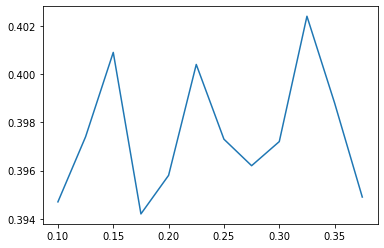

In [31]:
bias = []
acc = []

for factor in range(12):
    bias_factor = 0.1 + factor*0.025 # it means a 20 % probability to choose a class over the others
    bias.append(bias_factor)

    train_dataset = build_train_dataset_with_bias_factor(bias_factor)
    
    iterative_process = tff.learning.build_federated_averaging_process(Cifar10Model, client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.02))
    state = iterative_process.initialize()
    state, metrics = iterative_process.next(state, federated_train_data)
    num_rounds = 20
    for i in range(2, num_rounds+1):
        state, metrics = iterative_process.next(state, federated_train_data)
        
    evaluation = tff.learning.build_federated_evaluation(Cifar10Model)
    train_metrics = evaluation(state.model, federated_train_data)
    print('bias +', bias_factor, '- train metrics:', train_metrics)
    
    federated_test_data = make_federated_data(test_dataset, sample_users)
    test_metrics = evaluation(state.model, federated_test_data)
    print(test_metrics)
    
    acc.append(test_metrics['accuracy'])
    
plt.plot(bias, acc)